In [66]:
import os
import datetime
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [67]:
print("Num GPUs Available: ", tf.config.list_physical_devices())

Num GPUs Available:  [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [68]:
df = pd.read_csv('data/data_by_station/WT.zip', compression='zip', header=0, sep=',')
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d %H:%M:%S')
df = df.astype({'T': 'float', 'HR': 'float', 'P': 'float', 'u2': 'float', 'v2': 'float', 'u6': 'float', 'v6': 'float', 'u10': 'float', 'v10': 'float', 'altitud': 'float', 'latitud': 'float', 'longitud': 'float'})

In [69]:
df.head()

,T,HR,P,station,date,altitud,latitud,longitud,u2,v2,u6,v6,u10,v10
0,12.5,58.0,992.0,WT,2010-01-01 00:00:00,2.0,41.64707,2.75658,-1.0,-1.0,-1.0,-1.0,-2.7,-5.6
1,12.0,57.0,993.0,WT,2010-01-01 01:00:00,2.0,41.64707,2.75658,-1.0,-1.0,-1.0,-1.0,-1.3,-4.3
2,11.5,55.0,993.0,WT,2010-01-01 02:00:00,2.0,41.64707,2.75658,-1.0,-1.0,-1.0,-1.0,-1.6,-3.8
3,11.4,50.0,994.0,WT,2010-01-01 03:00:00,2.0,41.64707,2.75658,-1.0,-1.0,-1.0,-1.0,-1.6,-5.3
4,10.7,49.0,995.0,WT,2010-01-01 04:00:00,2.0,41.64707,2.75658,-1.0,-1.0,-1.0,-1.0,-2.0,-5.5


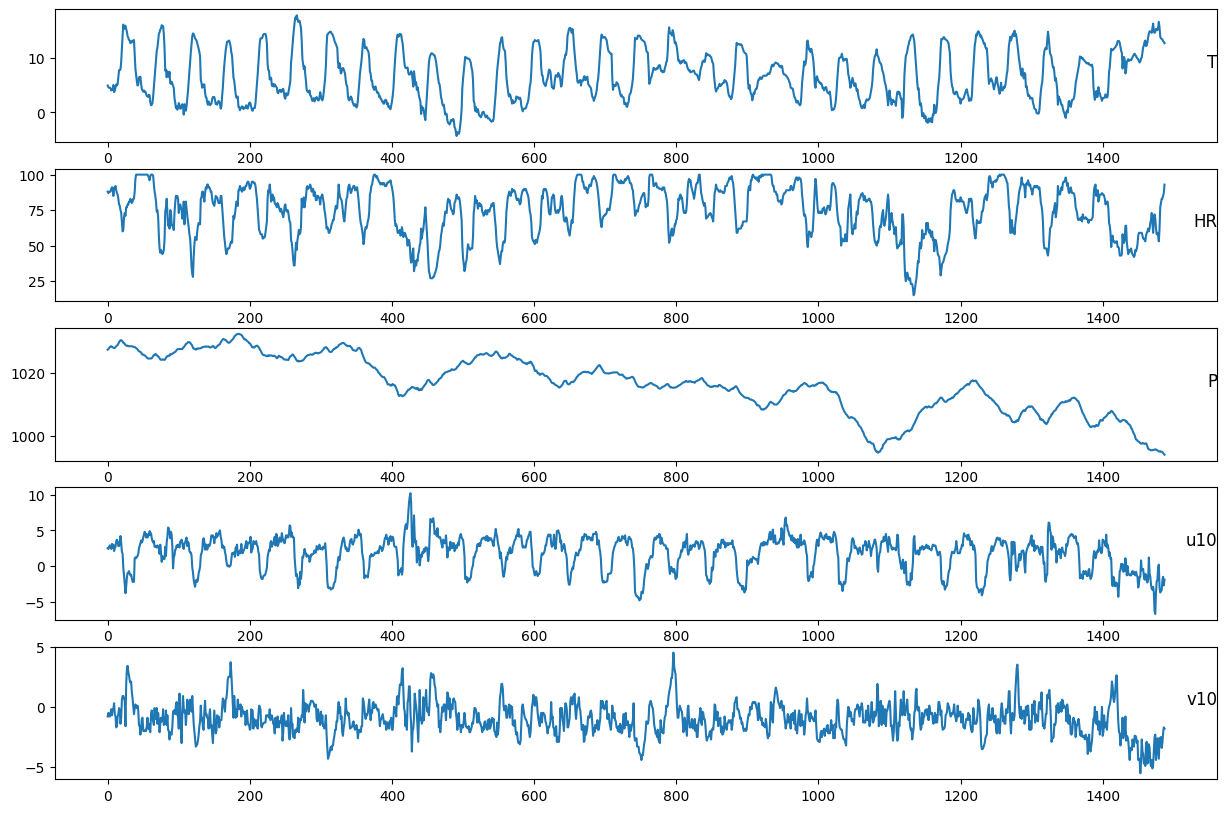

In [70]:
copy_df = df.copy()
copy_df.set_index('date', inplace=True)
copy_df = copy_df[(copy_df.index.year == 2019) & (copy_df.index.month == 1)]
groups = [0, 1, 2, 11, 12] 
i = 1
values = copy_df.values
plt.figure(figsize=(15, 10))
for group in groups:
    plt.subplot(len(groups), 1, i)
    plt.plot(values[:, group])
    plt.title(copy_df.columns[group], y=0.5, loc='right')
    i += 1
plt.savefig('plots/variables_month.png')
plt.show()
del copy_df, groups, i, values

In [71]:
df['day'] = df['date'].dt.dayofyear
df['time'] = df['date'].dt.hour * 60 + df['date'].dt.minute

cols = ['T', 'HR', 'P', 'u10', 'v10', 'day', 'time']
min_maxs = {}

for col in cols:
    min_maxs[col] = {'min': df[col].min(), 'max': df[col].max()}
    df[col] = (df[col] - df[col].min()) / (df[col].max() - df[col].min())

df = df[['T', 'HR', 'P', 'u10', 'v10', 'day', 'time', 'date']]

In [72]:
df.head()

,T,HR,P,u10,v10,day,time,date
0,0.466346,0.557895,0.953616,0.370656,0.176136,0.0,0.000000,2010-01-01 00:00:00
1,0.454327,0.547368,0.954576,0.424710,0.250000,0.0,0.042553,2010-01-01 01:00:00
2,0.442308,0.526316,0.954576,0.413127,0.278409,0.0,0.085106,2010-01-01 02:00:00
3,0.439904,0.473684,0.955536,0.413127,0.193182,0.0,0.127660,2010-01-01 03:00:00
4,0.423077,0.463158,0.956497,0.397683,0.181818,0.0,0.170213,2010-01-01 04:00:00


In [73]:
min_maxs

{'T': {'min': -6.9, 'max': 34.7},
 'HR': {'min': 5.0, 'max': 100.0},
 'P': {'min': -1.0, 'max': 1040.3},
 'u10': {'min': -12.3, 'max': 13.6},
 'v10': {'min': -8.7, 'max': 8.9},
 'day': {'min': 1, 'max': 366},
 'time': {'min': 0, 'max': 1410}}

# LSTM

In [74]:
input_width = 96
prediction_width = 1

df_train = df[df['date'] < '2019-01-01']
df_test = df[df['date'] >= '2019-01-01']

train_X = []
train_Y = []

for i in range(input_width, len(df_train) - prediction_width + 1):
    train_X.append(df_train.iloc[i - input_width:i][cols].values)
    train_Y.append(df_train.iloc[i:i + prediction_width][['T', 'u10', 'v10']].values)

test_X = []
test_Y = []

for i in range(input_width, len(df_test) - prediction_width + 1):
    test_X.append(df_test.iloc[i - input_width:i][cols].values)
    test_Y.append(df_test.iloc[i:i + prediction_width][['T', 'u10', 'v10']].values)

train_X = np.array(train_X)
train_Y = np.array(train_Y)

test_X = np.array(test_X)
test_Y = np.array(test_Y)

test_Y[:, 0, 0] = test_Y[:, 0, 0] * (min_maxs['T']['max'] - min_maxs['T']['min']) + min_maxs['T']['min']
test_Y[:, 0, 1] = test_Y[:, 0, 1] * (min_maxs['u10']['max'] - min_maxs['u10']['min']) + min_maxs['u10']['min']
test_Y[:, 0, 2] = test_Y[:, 0, 2] * (min_maxs['v10']['max'] - min_maxs['v10']['min']) + min_maxs['v10']['min']

In [79]:
neurons = [256]
for n in neurons:
    model = Sequential()
    model.add(LSTM(n, activation='tanh', input_shape=(train_X.shape[1], train_X.shape[2])))
    model.add(Dropout(0.2))
    model.add(Dense(units=3, activation='linear'))

    model.compile(optimizer='adam', loss='mse', metrics=['mae'])

    with tf.device('/device:GPU:0'):
        history = model.fit(train_X, train_Y, epochs=15, batch_size=32, validation_split=0.1, verbose=1, shuffle=False)
    model.save(f'models/lstm_{n}_15epochs_32bs.h5')

Epoch 1/15
3382/3382 [==============================] - 66s 19ms/step - loss: 0.0096 - mae: 0.0782 - val_loss: 0.0115 - val_mae: 0.0852
Epoch 2/15
3382/3382 [==============================] - 63s 19ms/step - loss: 0.0085 - mae: 0.0744 - val_loss: 0.0116 - val_mae: 0.0852
Epoch 3/15
3382/3382 [==============================] - 57s 17ms/step - loss: 0.0083 - mae: 0.0732 - val_loss: 0.0115 - val_mae: 0.0843
Epoch 4/15
3382/3382 [==============================] - 61s 18ms/step - loss: 0.0080 - mae: 0.0720 - val_loss: 0.0112 - val_mae: 0.0830
Epoch 5/15
3382/3382 [==============================] - 64s 19ms/step - loss: 0.0078 - mae: 0.0711 - val_loss: 0.0103 - val_mae: 0.0800
Epoch 6/15
3382/3382 [==============================] - 63s 19ms/step - loss: 0.0077 - mae: 0.0705 - val_loss: 0.0095 - val_mae: 0.0769
Epoch 7/15
3382/3382 [==============================] - 59s 17ms/step - loss: 0.0076 - mae: 0.0701 - val_loss: 0.0088 - val_mae: 0.0742
Epoch 8/15
3382/3382 [==========================

545/545 [==============================] - 4s 6ms/step


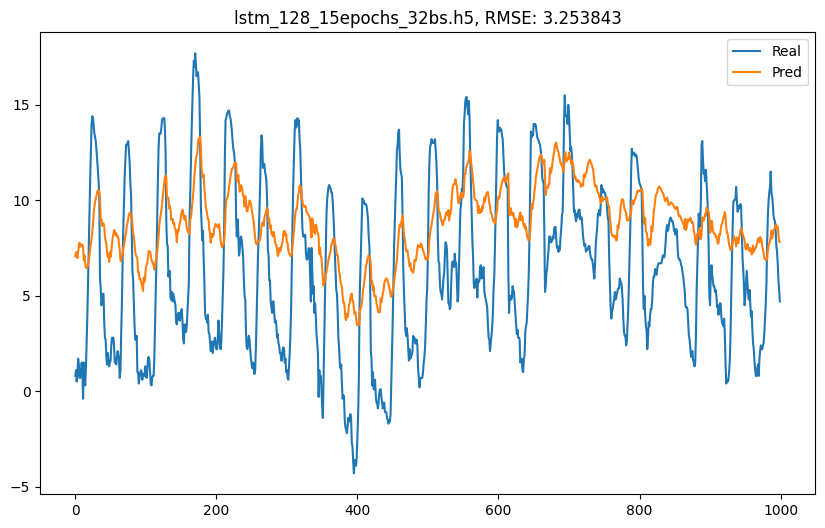

545/545 [==============================] - 3s 5ms/step


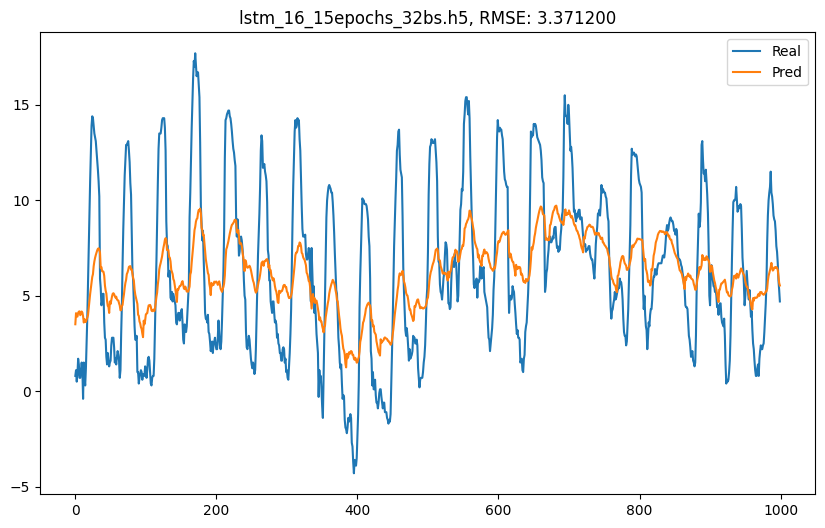

545/545 [==============================] - 4s 6ms/step


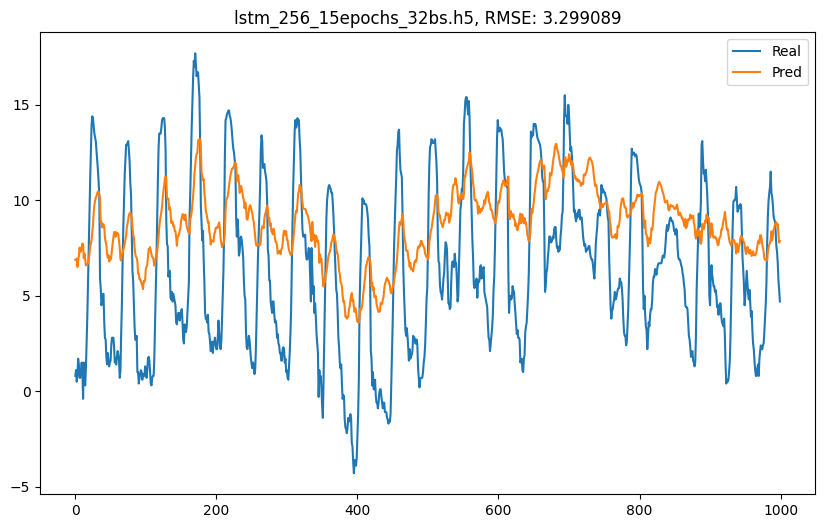

545/545 [==============================] - 3s 4ms/step


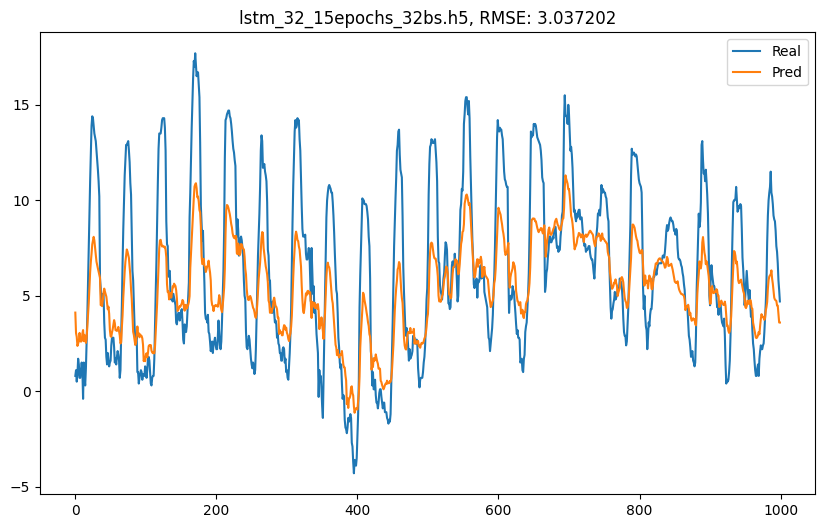

545/545 [==============================] - 3s 4ms/step


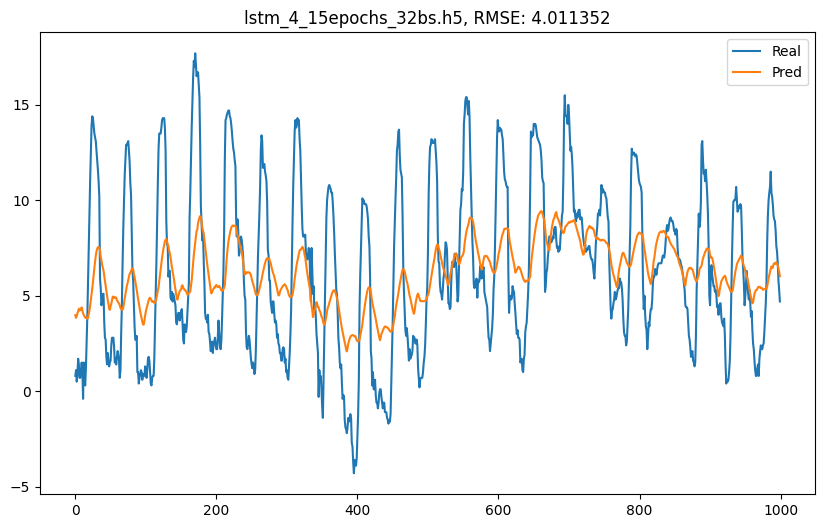

545/545 [==============================] - 3s 4ms/step


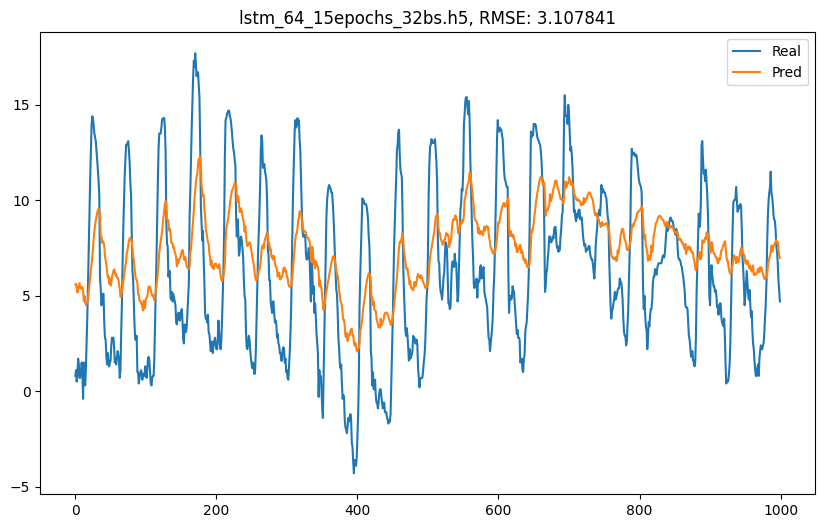

545/545 [==============================] - 3s 4ms/step


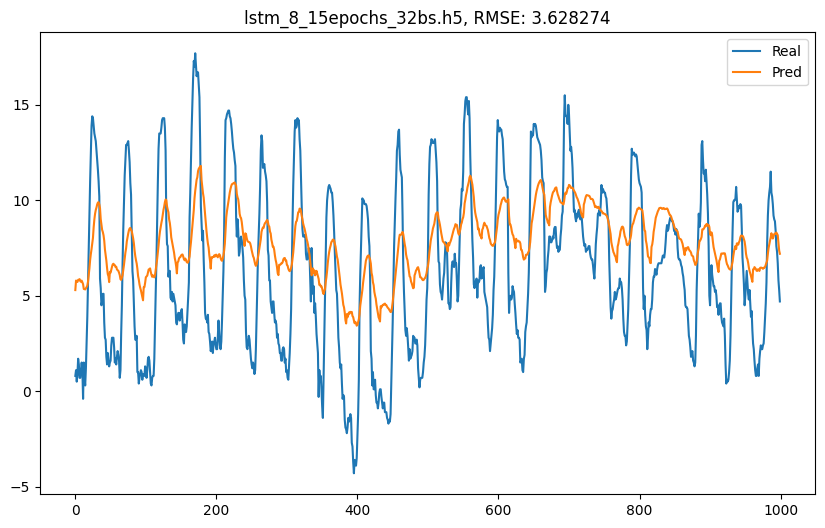

In [80]:
for model in os.listdir('models'):
    model_loaded = keras.models.load_model(f'models/{model}')

    y_pred = model_loaded.predict(test_X)

    plt.figure(figsize=(10, 6))
    y_pred[:, 0] = y_pred[:, 0] * (min_maxs['T']['max'] - min_maxs['T']['min']) + min_maxs['T']['min']
    
    plt.plot(test_Y[:1000, 0, 0], label='Real')
    plt.plot(y_pred[:1000, 0], label='Pred')
    
    rmse = np.sqrt(np.mean(np.power((test_Y[:, 0, 0] - y_pred[:, 0]), 2)))
    plt.legend()
    plt.title(f'{model}, RMSE: {rmse:.6f}')
    plt.show()


545/545 [==============================] - 4s 6ms/step


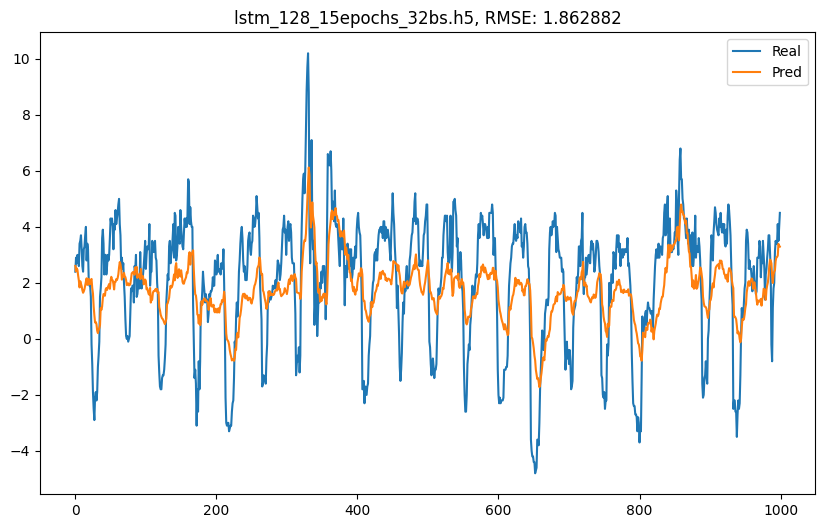

545/545 [==============================] - 3s 4ms/step


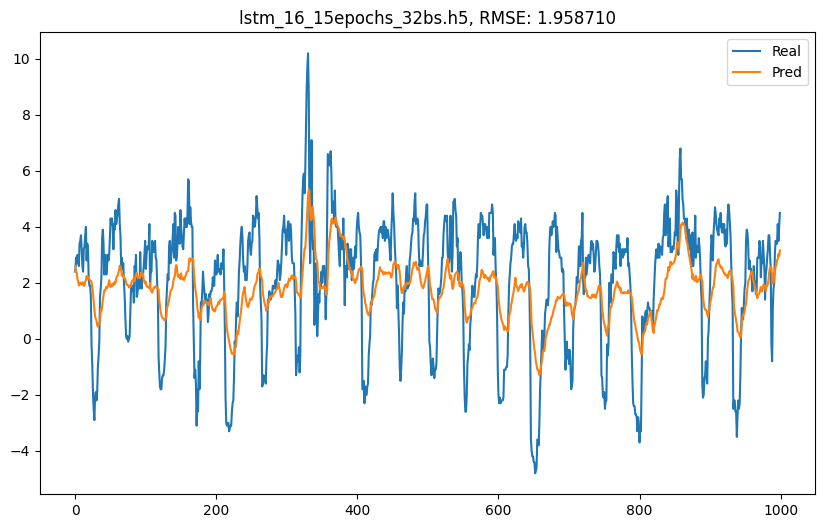

545/545 [==============================] - 4s 6ms/step


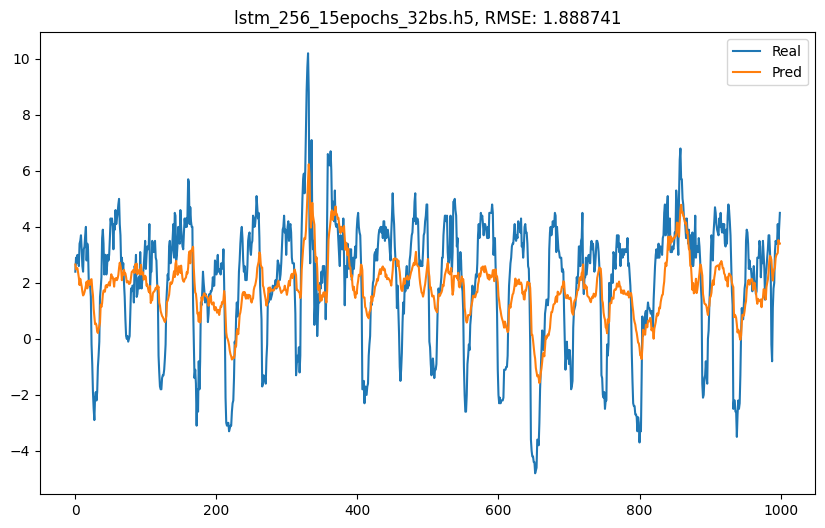

545/545 [==============================] - 3s 4ms/step


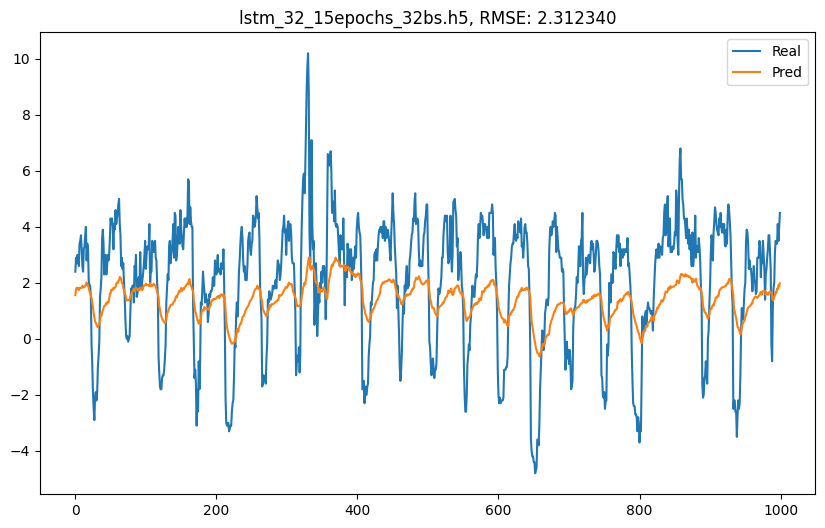

545/545 [==============================] - 3s 4ms/step


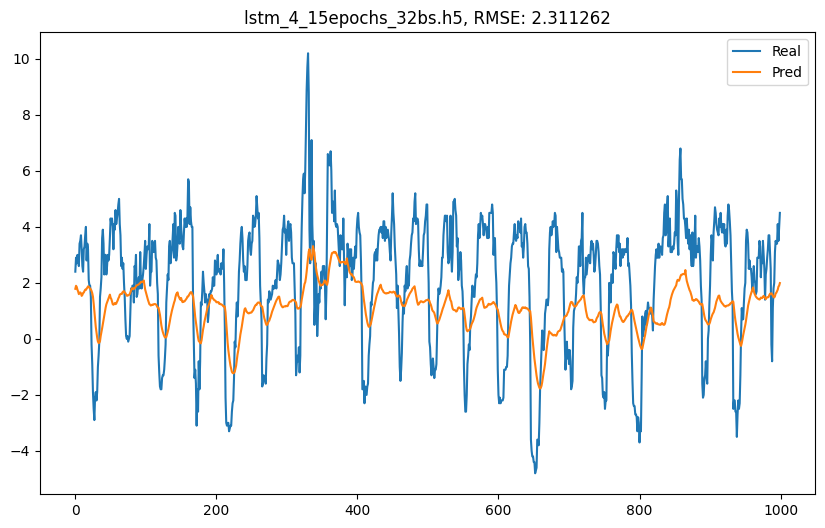

545/545 [==============================] - 3s 5ms/step


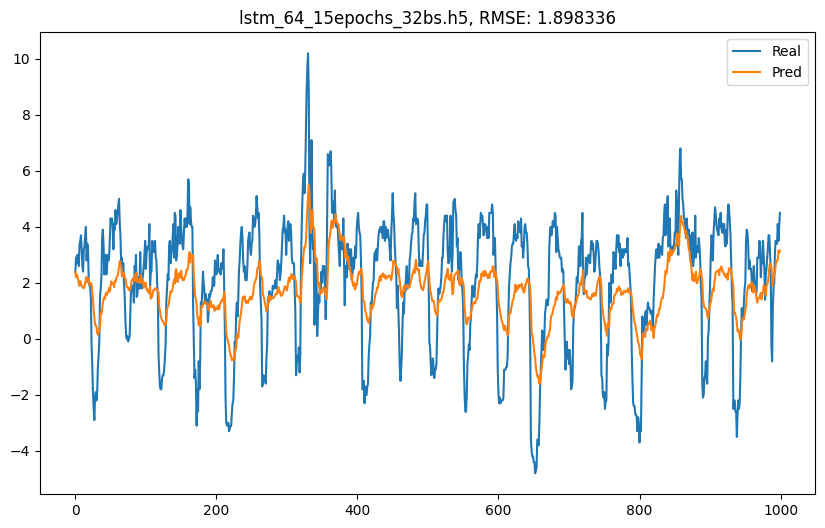

545/545 [==============================] - 3s 5ms/step


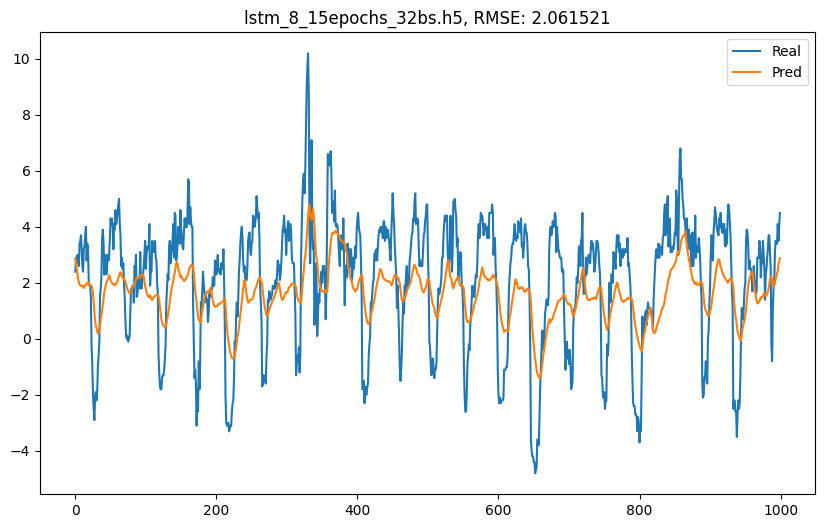

In [81]:
for model in os.listdir('models'):
    model_loaded = keras.models.load_model(f'models/{model}')

    y_pred = model_loaded.predict(test_X)

    plt.figure(figsize=(10, 6))
    y_pred[:, 1] = y_pred[:, 1] * (min_maxs['u10']['max'] - min_maxs['u10']['min']) + min_maxs['u10']['min']
    
    plt.plot(test_Y[:1000, 0, 1], label='Real')
    plt.plot(y_pred[:1000, 1], label='Pred')
    
    rmse = np.sqrt(np.mean(np.power((test_Y[:, 0, 1] - y_pred[:, 1]), 2)))
    plt.legend()
    plt.title(f'{model}, RMSE: {rmse:.6f}')
    plt.show()

545/545 [==============================] - 4s 6ms/step


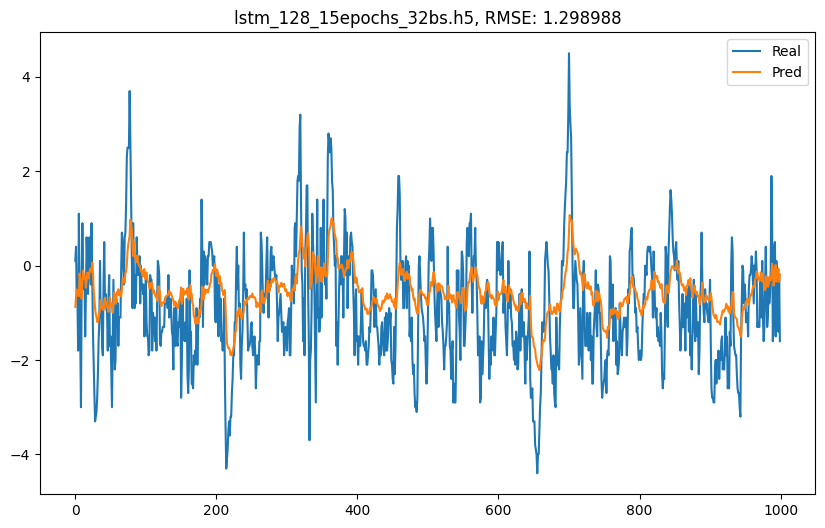

545/545 [==============================] - 3s 5ms/step


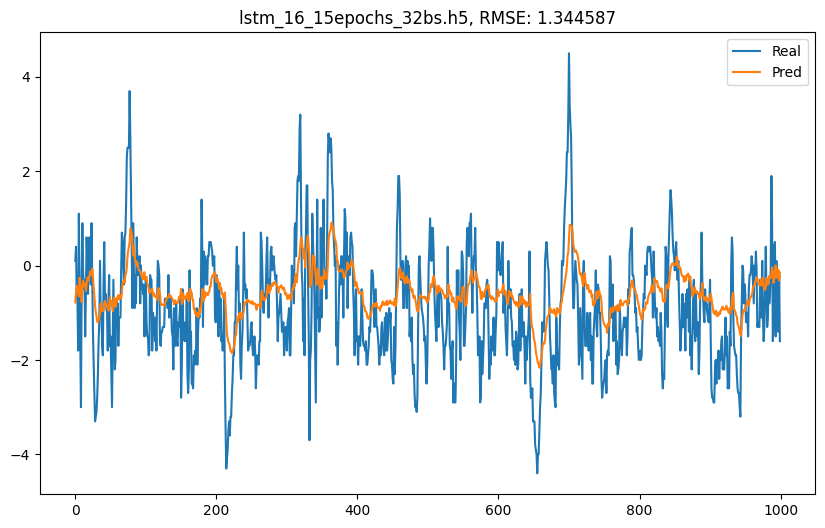

545/545 [==============================] - 4s 6ms/step


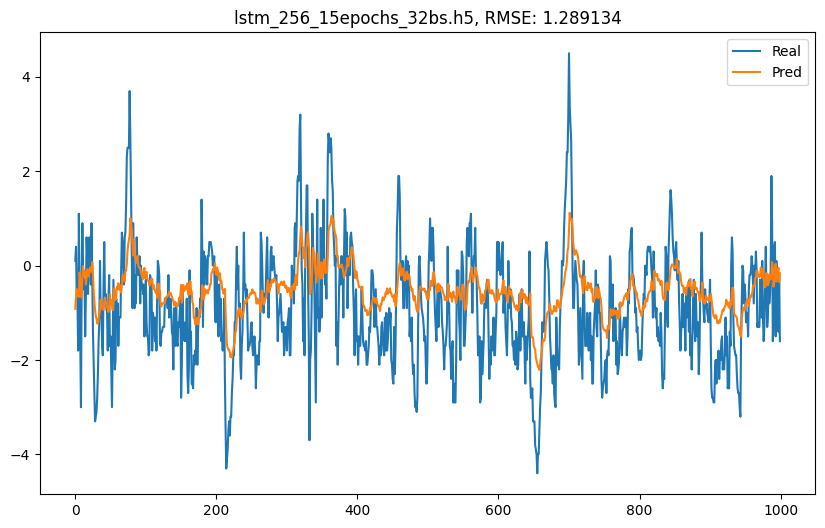

545/545 [==============================] - 4s 5ms/step


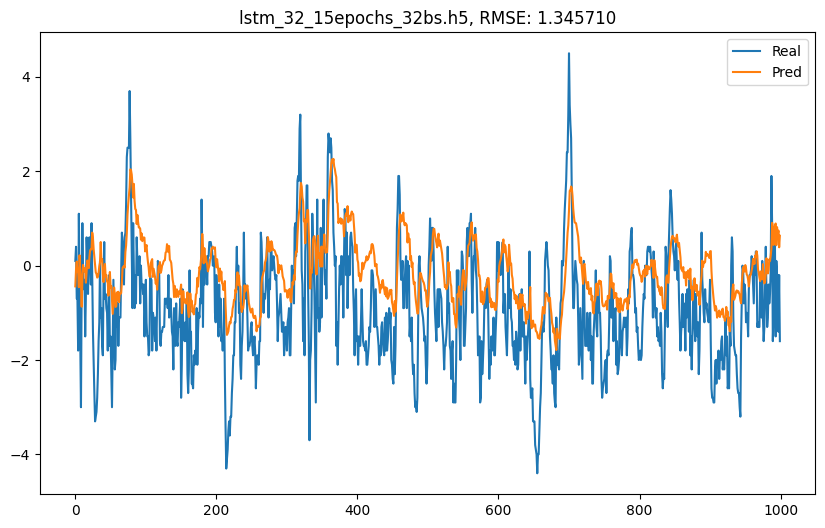

545/545 [==============================] - 3s 5ms/step


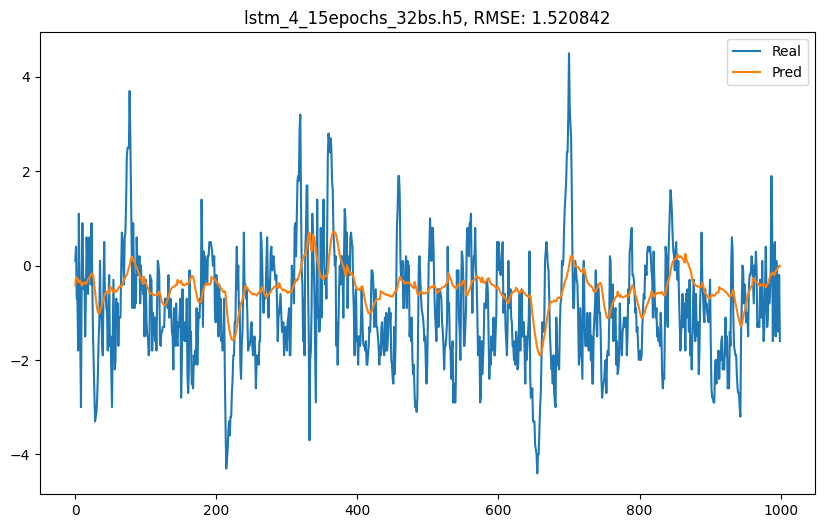

545/545 [==============================] - 3s 5ms/step


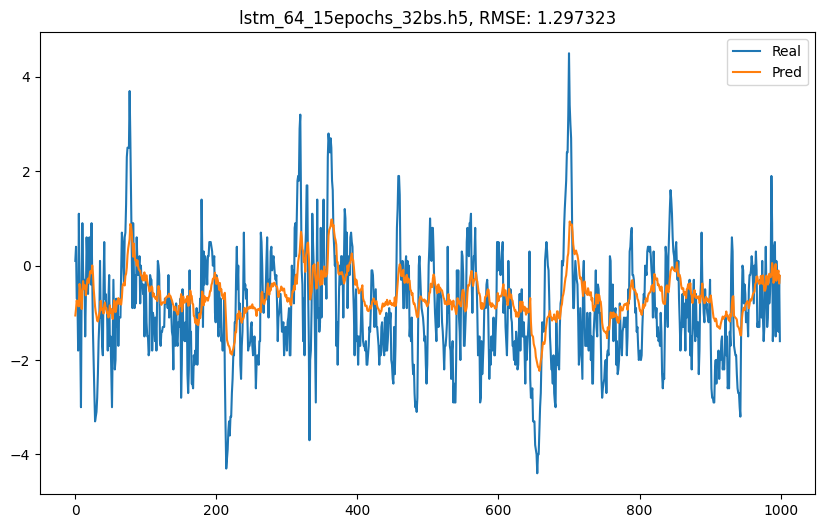

545/545 [==============================] - 3s 5ms/step


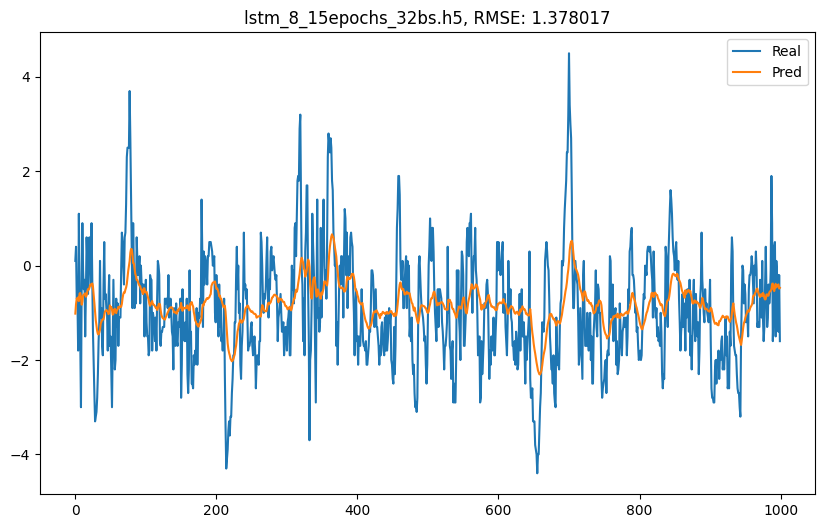

In [82]:
for model in os.listdir('models'):
    model_loaded = keras.models.load_model(f'models/{model}')

    y_pred = model_loaded.predict(test_X)

    plt.figure(figsize=(10, 6))
    y_pred[:, 2] = y_pred[:, 2] * (min_maxs['v10']['max'] - min_maxs['v10']['min']) + min_maxs['v10']['min']
    
    plt.plot(test_Y[:1000, 0, 2], label='Real')
    plt.plot(y_pred[:1000, 2], label='Pred')
    
    rmse = np.sqrt(np.mean(np.power((test_Y[:, 0, 2] - y_pred[:, 2]), 2)))
    plt.legend()
    plt.title(f'{model}, RMSE: {rmse:.6f}')
    plt.show()

In [84]:
%reset -f